# Retrofit to a subgraph extracted from the Roam Health Knowledge Graph

In [1]:
import numpy as np
import scipy
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import time

import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '../../'))
import evaluate
from retrofit_identity import retrofit_identity
from retrofit_linear   import retrofit_linear
from retrofit_neural   import retrofit_neural
from utils import *

In [2]:
X = load_obj("X_dim_10")
retrofit_edges = load_obj("retrofit_edges")
retrofit_edges_out = load_obj("retrofit_edges_out")
print("X shape: {}".format(X.shape))
X = normalize(X, norm='l2')

X shape: (3370, 10)


In [7]:
# Train Classifier
clf_edges = load_obj('clf_edges')
index_by_name = load_obj('index_by_name')
p_train = 0.8
n_iters = 3
scores = {
    'Dummy' : [],
    'Raw' : [],
    'Identity' : [],
    'Linear' : [],
    'Neural' : []
}
for iteration in range(1, n_iters+1):
    print("="*60)
    print("Iteration {} of {}".format(iteration, n_iters))
    print("="*60)
    train_indices, test_indices, neg_train_indices, neg_test_indices = get_train_test_indices(
        clf_edges, p_train)
    Y_train = np.ones(len(train_indices))
    Y_train = np.concatenate((Y_train, np.zeros((len(neg_train_indices), ))))
    Y_test = np.ones(len(test_indices))
    Y_test = np.concatenate((Y_test, np.zeros((len(neg_test_indices), ))))
    train_indices.extend(neg_train_indices)
    test_indices.extend(neg_test_indices)
    make_train = lambda rep: np.array([np.hstack((rep[i], rep[j])) for (i,j) in train_indices])
    make_test = lambda rep: np.array([np.hstack((rep[i], rep[j])) for (i,j) in test_indices])
    def make_train_lin(rep):
        ar = []
        for (i,j) in train_indices:
            a = rep[j]
            b = rep[i]
            ar.append(np.hstack((a, b)))
        return np.array(ar)
    def make_test_lin(rep):
        ar = []
        for (i,j) in test_indices:
            a = rep[j]
            b = rep[i]
            ar.append(np.hstack((a, b)))
        return np.array(ar)

    def make_train_neu(rep, r='treats'):
        ar = []
        for (i,j) in train_indices:
            a = rep[j]
            #a = np.squeeze(U[r].dot(np.tanh(A[r].dot(np.expand_dims(rep[j], 1))) + B[r]))
            b = rep[i]
            ar.append(np.hstack((a, b)))
        return np.array(ar)

    def make_test_neu(rep, r='treats'):
        ar = []
        for (i,j) in test_indices:
            a = rep[j]
            #a = np.squeeze(U[r].dot(np.tanh(A[r].dot(np.expand_dims(rep[j], 1))) + B[r]))
            b = rep[i]
            ar.append(np.hstack((a, b)))
        return np.array(ar)

    # Retrofitting Methods
    # Identity Retrofitting
    print("-"*40 + "\nIdentity Retrofitting\n" + '-'*40)
    t = time.time()
    X_ide = retrofit_identity(
        X, retrofit_edges, alpha=lambda i: 0.1, n_iter=20, verbose=True)
    print("Took {:.2f} seconds.".format(time.time() - t))
    save_obj(X_ide, 'retrofitted_identity')
    
    # Linear Retrofitting
    print("-"*40 + "\nLinear Retrofitting\n" + "-"*40)
    t = time.time()
    X_lin, A, B = retrofit_linear(
        X, retrofit_edges, retrofit_edges_out, orthogonal=True,
        n_iter=100, lam=1e-5, lr=1.0, lr_decay=0.99,
        tol=1e-5, alpha=lambda i: 0.1, verbose=True)
    print("Linear took {:.2f} seconds.".format(time.time() - t))
    save_obj(X_lin, 'retrofitted_linear')
    
    # Neural Retrofitting
    print("-"*40 + "\nNeural Retrofitting\n" + "-"*40)
    t = time.time()
    X_neu, A, u, b = retrofit_neural(
        X, retrofit_edges, retrofit_edges_out, alpha=lambda i: 0.1, k=5,
        n_iter=2000, lam=1e-6, lr=0.005, lr_decay=0.99,
        batch_size=512, patience=5, verbose=5, tol=1e-5)
    print("Neural retrofitting took {:.2f} seconds.".format(time.time() - t))
    save_obj((X_neu, A, u, b), 'retrofitted_neural')
    
    # Evaluation
    # Dummy Classifier
    dummy = DummyClassifier(strategy='most_frequent')
    score = evaluate.evaluate(X, Y_train, Y_test, make_train, make_test, dummy)
    scores['Dummy'].append(score)
    
    # Random Forest Classifiers
    rf_raw = RandomForestClassifier(n_estimators=50, criterion='entropy')
    rf_ide = RandomForestClassifier(n_estimators=50, criterion='entropy')
    rf_lin = RandomForestClassifier(n_estimators=50, criterion='entropy')
    rf_neu = RandomForestClassifier(n_estimators=50, criterion='entropy')

    # Evaluate Distributional
    score, rf_raw, _, X_test = evaluate.evaluate(X, Y_train, Y_test, make_train, make_test, rf_raw)
    scores['Raw'].append(score)
    
    # Evaluate Identity Retrofitting
    score, rf_ide, _, X_test_ide = evaluate.evaluate(X_ide, Y_train, Y_test, make_train, make_test, rf_ide)
    scores['Identity'].append(score)
    
    # Evaluate Linear Retrofitting
    score, rf_lin, _, X_test_lin = evaluate.evaluate(X_lin, Y_train, Y_test, make_train_lin, make_test_lin, rf_lin)
    scores['Linear'].append(score)
    
    # Evaluate Neural Retrofitting
    score, rf_neu, _, X_test_neu = evaluate.evaluate(X_neu, Y_train, Y_test, make_train_neu, make_test_neu, rf_neu)
    scores['Neural'].append(score)


print("="*40 + "\nAccuracies for Edges of Type 'Treats': (# training: {}, # testing: {})".format(
    len(Y_train), len(Y_test)))
print_accuracy = lambda name, scores: print("{}: {:.4f}+-{:.4f}".format(
                    name, np.mean(scores[name]), np.std(scores[name])))
print_accuracy("Dummy", scores)
print_accuracy("Raw", scores)
print_accuracy("Identity", scores)
print_accuracy("Linear", scores)
print_accuracy("Neural", scores)

Iteration 1 of 3
----------------------------------------
Identity Retrofitting
----------------------------------------
Converged at iteration 18
Took 1.75 seconds.
----------------------------------------
Linear Retrofitting
----------------------------------------
Iteration 1 of 100	Changes: 30.873	Loss: 1519.536
Iteration 2 of 100	Changes: 23.923	Loss: 865.291
Loss reached local minimum at iteration 2
Linear took 64.21 seconds.
----------------------------------------
Neural Retrofitting
----------------------------------------
Iteration 5 of 2000	Changes: 0.00215	Loss: 1.022	Patience: 4
Iteration 10 of 2000	Changes: 0.01072	Loss: 0.494	Patience: 3
Iteration 15 of 2000	Changes: 0.00773	Loss: 0.633	Patience: 1
Loss reached local minimum (and patience expired) at iteration 19
Neural retrofitting took 57.96 seconds.
Iteration 2 of 3
----------------------------------------
Identity Retrofitting
----------------------------------------
Converged at iteration 18
Took 1.77 seconds.
-----

## Look at new drug re-target predictions 

In [17]:
print("Predictions of new Edges of Type 'Treats':")
print("-"*40 + "\nDistributional Data\n" + "-"*40)
evaluate.print_predictions(rf_raw, X_test, Y_test, index_by_name, test_indices)
print("-"*40 + "\nIdentity Retrofitting\n" + "-"*40)
evaluate.print_predictions(rf_ide, X_test_ide, Y_test, index_by_name, test_indices)
#evaluate.print_predictions(rf_ide, X_train_ide, Y_train, index_by_name, train_indices)
print('-'*40 + "\nLinear Retrofitting\n" + '-'*40)
evaluate.print_predictions(rf_lin, X_test_lin, Y_test, index_by_name, test_indices)
#evaluate.print_predictions(rf_lin, X_train_lin, Y_train, index_by_name, train_indices)
print('-'*40 + "\nNeural Retrofitting\n" + '-'*40)
evaluate.print_predictions(rf_neu, X_test_neu, Y_test, index_by_name, test_indices)
#evaluate.print_predictions(rf_neu, X_train_neu, Y_train, index_by_name, train_indices)

Predictions of new Edges of Type 'Treats':
----------------------------------------
Distributional Data
----------------------------------------
Predicted drug 'onglyza' TREATS 'Type 2 diabetes mellitus' with score: 0.9800.
Predicted drug 'pradaxa' TREATS 'Essential (primary) hypertension' with score: 0.9800.
Predicted drug 'lipitor' TREATS 'Cerebral infarction' with score: 0.9600.
Predicted drug 'octreotide acetate' TREATS 'Ulcerative colitis, unspecified' with score: 0.9400.
Predicted drug 'oxytocin' TREATS 'Pauciarticular juvenile rheumatoid arthritis, unsp site' with score: 0.9400.
Predicted drug 'terbutaline sulfate' TREATS 'HIV 2 as the cause of diseases classified elsewhere' with score: 0.9400.
Predicted drug 'glimepiride' TREATS 'Osteomyelitis' with score: 0.9200.
Predicted drug 'dutoprol' TREATS 'Hyperlipidemia, unspecified' with score: 0.9000.
Predicted drug 'depacon' TREATS 'Migraine, unsp, not intractable, without status migrainosus' with score: 0.9000.
Predicted drug 'sala

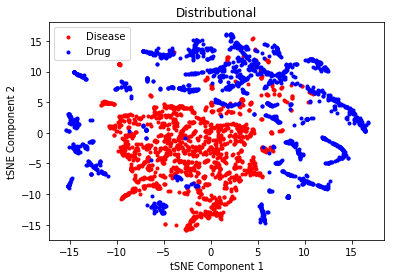

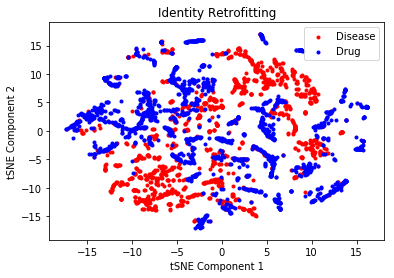

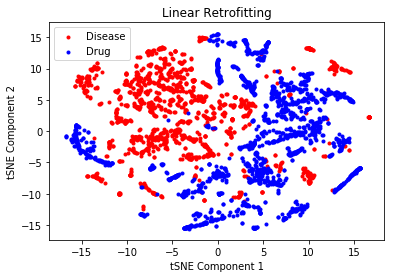

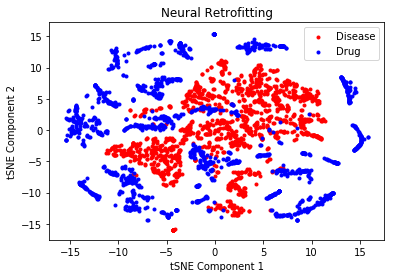

In [10]:
plot = lambda x, title: plot_embeddings(x, title, ['Disease', 'Drug'],
                    [1568, len(X)-1568], n_iter=200)
plot(X,     'Distributional')
plot(X_ide, 'Identity Retrofitting')
plot(X_lin, 'Linear Retrofitting')
plot(X_neu, 'Neural Retrofitting')